In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
leaves = os.listdir('leaves/')
leaves

['1', '2', '3', '4', '5', '6', '7', '8']

In [3]:

image_paths = []
labels = []

for class_index, folder in enumerate(leaves, start=1):
    folder_path = os.path.join('leaves', folder)
    file_list = os.listdir(folder_path)
    
    for file_name in file_list:
        # Yalnızca resim uzantılı dosyaları işlemek isterseniz filtre koyabilirsiniz:
        ext = os.path.splitext(file_name)[1].lower()
        if ext not in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            continue
        
        full_path = os.path.join(folder_path, file_name)
        image_paths.append(full_path)
        labels.append(class_index)

# Python listelerini numpy array'e dönüştürelim (kolay işlenebilmesi için):
image_paths = np.array(image_paths)
labels = np.array(labels)

print("Toplam resim sayısı:", len(image_paths))
print("Örnek label:", labels[0])


Toplam resim sayısı: 3221
Örnek label: 1


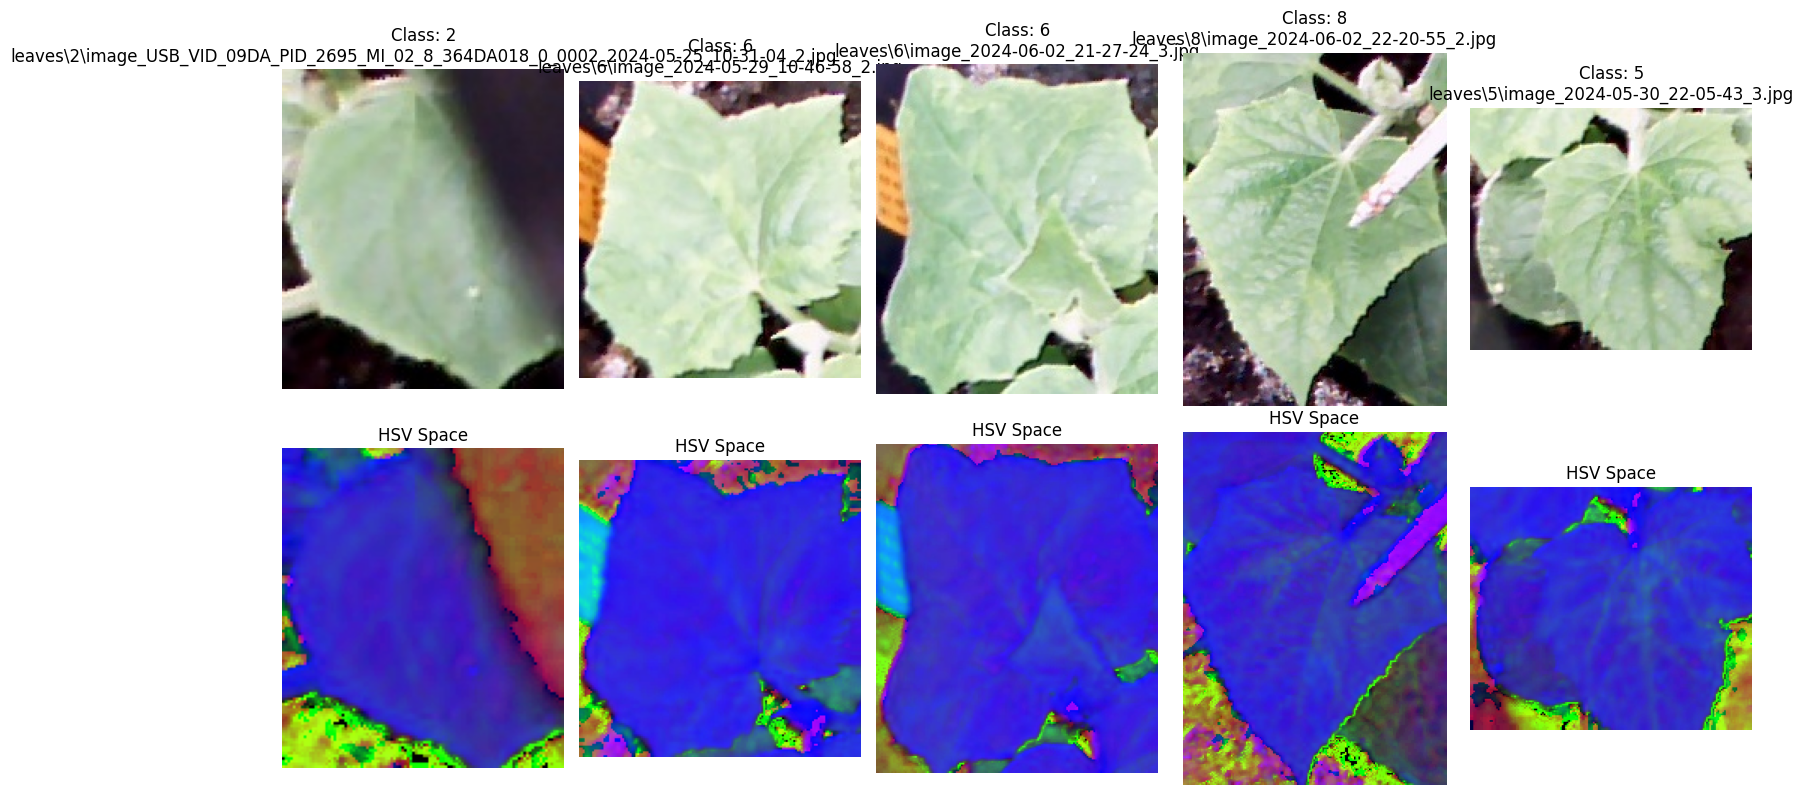

Unique image shapes: [[156 180   3]
 [156 182   3]
 [156 184   3]
 [158 176   3]
 [158 178   3]
 [158 180   3]
 [158 182   3]
 [160 178   3]
 [160 180   3]
 [160 182   3]
 [160 184   3]
 [162 182   3]
 [162 184   3]
 [162 186   3]
 [164 184   3]
 [164 186   3]
 [164 188   3]
 [164 190   3]]


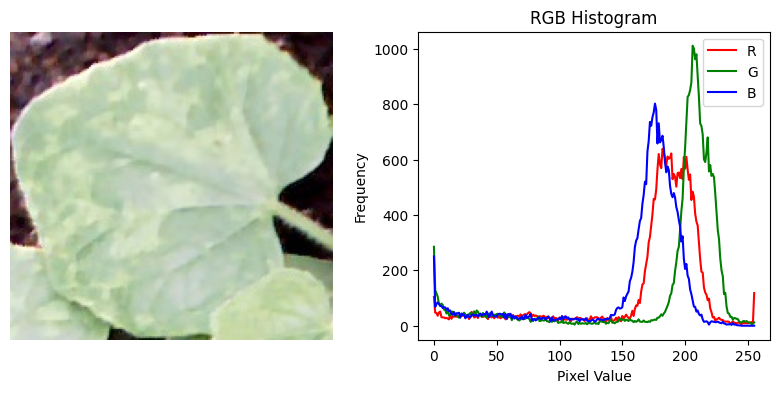

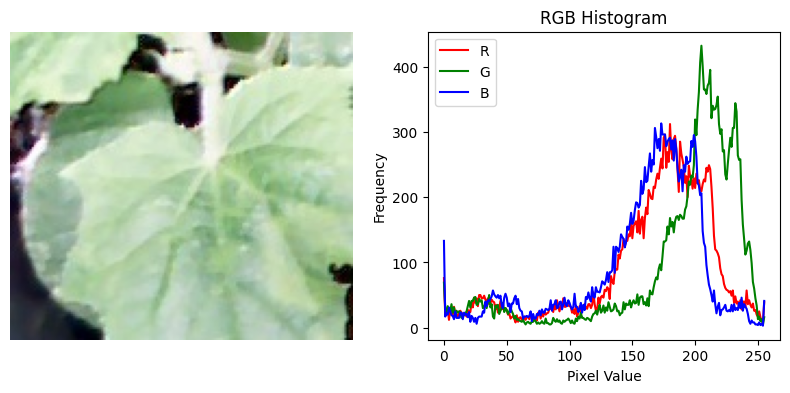

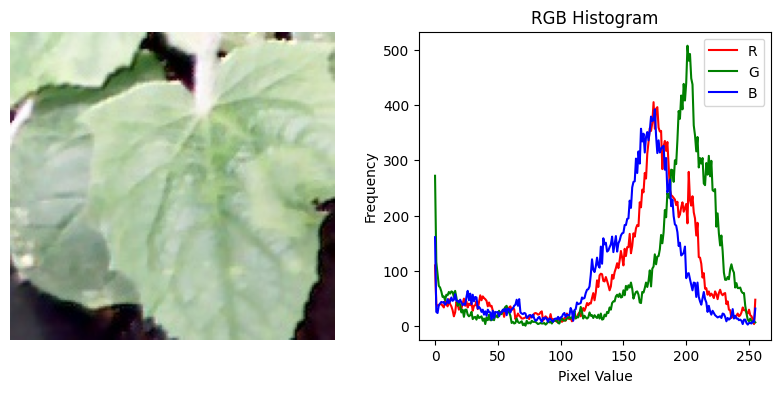

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure

# 1. Veri Yapısını Anlama
# ------------------------------------------------
# Klasör yapısı: leaves/1/, leaves/2/, ..., leaves/8/
# Her klasörde zaman serisi resimler (örneğin image_2024-05-27_16-41-31_0.jpg)

# 2. Görsel Keşif (EDA)
# ------------------------------------------------
def plot_sample_images(image_paths, labels, n=5):
    plt.figure(figsize=(15, 8))
    for i in range(n):
        idx = np.random.randint(0, len(image_paths))
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV BGR -> RGB
        
        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Class: {labels[idx]}\n{image_paths[idx].split('/')[-1]}")
        plt.axis('off')
        
        # HSV Renk Uzayında Analiz
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        plt.subplot(2, n, n+i+1)
        plt.imshow(hsv)
        plt.title("HSV Space")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(image_paths, labels)

# 3. Temel İstatistikler
# ------------------------------------------------
# Tüm resimlerin boyutlarını ve kanal sayısını kontrol et
shapes = []
for path in image_paths[:100]:  # İlk 100'ü örnek olarak kontrol et
    img = cv2.imread(path)
    shapes.append(img.shape)

unique_shapes = np.unique(shapes, axis=0)
print(f"Unique image shapes: {unique_shapes}")

# 4. Renk Dağılımı Analizi
# ------------------------------------------------
def plot_color_histogram(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    for i, col in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col, label=col.upper())
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("RGB Histogram")
    plt.show()

# Rastgele 3 resmin histogramını çizdir
for _ in range(3):
    rand_idx = np.random.randint(len(image_paths))
    plot_color_histogram(image_paths[rand_idx])

In [21]:
df = pd.DataFrame({'image_path': image_paths, 'label': labels})
df

,image_path,label
0,leaves\1\image_2024-05-27_16-41-31_0.jpg,1
1,leaves\1\image_2024-05-27_16-52-13_0.jpg,1
2,leaves\1\image_2024-05-27_17-02-54_0.jpg,1
3,leaves\1\image_2024-05-27_17-13-36_0.jpg,1
4,leaves\1\image_2024-05-27_17-24-18_0.jpg,1
...,...,...
3216,leaves\8\image_2024-06-04_13-57-18_2.jpg,8
3217,leaves\8\image_2024-06-04_14-08-01_2.jpg,8
3218,leaves\8\image_2024-06-04_14-18-43_2.jpg,8
3219,leaves\8\image_2024-06-04_14-29-25_2.jpg,8


In [ ]:
def auto_label_based_on_color(img_path, green_threshold=100):
    img = cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Yeşil pikselleri say
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    green_percentage = np.mean(mask > 0)
    # Mavi pikselleri say
    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    blue_percentage = np.mean(mask > 0)
    # Mavi piksellerin yüzdesini hesapla
    print(blue_percentage)
    # Eşik değere göre etiketle
    return 1 if blue_percentage > 0.4 else 0

# Tüm resimlere uygula
df['auto_label'] = df['image_path'].apply(auto_label_based_on_color)

0.004674913693901036
0.009244773147489688
0.0046935002133409185
0.002311193286872422
0.004279344073647871
0.0029487917146144996
0.004279344073647871
0.003775891829689298
0.006185270425776755
0.006688722669735328
0.006149309551208285
0.004710874568469505
0.003200517836593786
0.003560126582278481
0.007551783659378596
0.0044591484464902185
0.008342922899884924
0.008306962025316455
0.0053335229697055895
0.004657943393542882
0.006080216185464372
0.003093443322429242
0.009742568624662211
0.005653534347887925
0.004360056258790436
0.007172995780590718
0.004024216524216524
0.011858974358974358
0.00935456948115176
0.00641025641025641
0.01112989574528036
0.0062341504649196956
0.010531135531135532
0.01267962806424345
0.006828316610925307
0.01039025077486616
0.006479933110367893
0.0002035002035002035
0.000407000407000407
0.001098901098901099
0.0005151098901098901
0.0006597222222222222
0.0004166666666666667
0.0016666666666666668
0.001388888888888889
0.00125
0.001388888888888889
0.0011458333333333333

In [28]:
df

,image_path,label,auto_label
0,leaves\1\image_2024-05-27_16-41-31_0.jpg,1,1
1,leaves\1\image_2024-05-27_16-52-13_0.jpg,1,1
2,leaves\1\image_2024-05-27_17-02-54_0.jpg,1,1
3,leaves\1\image_2024-05-27_17-13-36_0.jpg,1,1
4,leaves\1\image_2024-05-27_17-24-18_0.jpg,1,1
...,...,...,...
3216,leaves\8\image_2024-06-04_13-57-18_2.jpg,8,1
3217,leaves\8\image_2024-06-04_14-08-01_2.jpg,8,1
3218,leaves\8\image_2024-06-04_14-18-43_2.jpg,8,1
3219,leaves\8\image_2024-06-04_14-29-25_2.jpg,8,1
